# Consultas Integradas

Este notebook tiene el fin de generar las consultas planteadas en el trabajo práctico integrador

#### Importo librerias

In [ ]:
# Limpia todas las variables existentes
%reset -f

# Habilita autoreload para recargar automáticamente todos los módulos
%load_ext autoreloadj

In [1]:
import os
from pathlib import Path
import pandas as pd
from pymongo.errors import ConnectionFailure
from db_connections import client, db_neo4j, db_redis
from src import mongo, neo4j, utils, redis
from IPython.display import display
import matplotlib.pyplot as plt
from constants import NOMBRE_BD_MONGO

In [2]:
# =====================
# TEST DE CONEXIONES
# =====================

#Conecto con MongoDB
try:
    client.admin.command("ping")  # fuerza conexión al servidor
    print("✅ Conexión a MongoDB verificada.")
except ConnectionFailure as e:
    print(f"❌ Falló la conexión: {type(e).__name__} - {e}")

#Conecto con Neo4j
try:
    db_neo4j.verify_connectivity()
    print("✅ Conexión a Neo4j verificada.")
except Exception as e:
    print(f"❌ Error de conexión: {type(e).__name__} - {e}")

#Conecto con Redis
try:
    db_redis.ping()
    print("✅ Conexión a Redis verificada.")
except Exception as e:
    print(f"❌ Error de conexión: {type(e).__name__} - {e}")

✅ Conexión a MongoDB verificada.
✅ Conexión a Neo4j verificada.
✅ Conexión a Redis verificada.


### A.Mostrar los usuarios que visitaron “Bariloche”. 

In [14]:
query = """ 
MATCH (U:Usuario)-[:VISITO]->(D:Destino)
WHERE D.ciudad='Bariloche'
RETURN U.nombre AS Nombre, U.apellido AS Apellido
"""

usuarios = neo4j.consulta(db_neo4j, query)

print("\n" + "-"*60)
print("USUARIOS QUE VISITARON BARILOCHE")
print("-"*60)
display(usuarios.style.hide(axis="index"))


------------------------------------------------------------
USUARIOS QUE VISITARON BARILOCHE
------------------------------------------------------------


Nombre,Apellido
Tito,Montserrat
Gema,Yáñez
Leopoldo,Agudo
Carmen,Roma
Lucas,Cruz
Georgina,Talavera
Calista,Catalán
Graciana,Murillo
Adrián,Belda
Juan José,Romero


### B.Mostrar los amigos de Juan que visitaron algún destino que visitó él, mostrar el nombre del Usuario y el destino. 

In [15]:
# Pedimos el nombre del usuario
nombre_usuario = input("Introduce tu nombre para saber qué lugares visitaste con tus amigos: ")


query = """
MATCH (u:Usuario)
WHERE toLower(u.nombre) CONTAINS toLower($nombre)
MATCH (u)-[:AMIGO_DE]-(amigo:Usuario)
MATCH (u)-[:VISITO]->(d:Destino)<-[:VISITO]-(amigo)
RETURN 
    amigo.nombre AS Nombre,
    collect(DISTINCT d.ciudad) AS Destinos_Compartidos
ORDER BY Nombre
"""

#Encabezado
print("\n" + "-"*60)
print(f"{nombre_usuario.upper()} TUS AMIGOS VISITARON ESTOS MISMOS DESTINOS QUE TÚ")
print("-"*60 + "\n")

# Ejecutamos la consulta usando la función consulta() que devuelve un DataFrame
usuarios = neo4j.consulta(db_neo4j, query, parametros={"nombre": nombre_usuario})

# Convertimos listas a texto legible
usuarios["Destinos_Compartidos"] = usuarios["Destinos_Compartidos"].apply(
    lambda lista: ", ".join(lista) if isinstance(lista, list) else lista
)

# Mostramos el resultado
if usuarios.empty:
    print("No se encontraron amigos que hayan visitado los mismos destinos.")
else:
    display(usuarios.style.hide(axis="index"))

Introduce tu nombre para saber qué lugares visitaste con tus amigos:  Tito



------------------------------------------------------------
TITO TUS AMIGOS VISITARON ESTOS MISMOS DESTINOS QUE TÚ
------------------------------------------------------------



Nombre,Destinos_Compartidos
Amor,"CABA, San Fernando, San Salvador de Jujuy, Iguazú"
Ciro,"Río Cuarto, Concordia, Gualeguaychú, San Juan"
Eliseo,"CABA, Villa Carlos Paz, Río Cuarto, Santa Rosa, Iguazú"
Emiliana,"Santa Rosa, Iguazú, Viedma"
Enrique,"Formosa, Iguazú, Bariloche"
Feliciano,"Formosa, San Salvador de Jujuy, Santa Rosa, Bariloche"
Gema,"CABA, Río Cuarto, Concordia, Gualeguaychú, Santa Rosa, Iguazú, Salta, San Juan"
Jose Francisco,"Río Cuarto, Concordia"
Juan Manuel,"San Fernando, Gualeguaychú, Santa Rosa, Iguazú"
Mariana,"Río Cuarto, Iguazú, San Juan, Santa Fe"


### C. Sugerir destinos a un usuario que no haya visitado él ni sus amigos. 

In [ ]:
nombre_usuario = input("Introduce tu nombre para saber qué lugares nuevos que no visitaste ni tu ni tus amigos: ")

query = """
MATCH (u:Usuario)
WHERE toLower(u.nombre) CONTAINS toLower($nombre)
MATCH (d:Destino)
WHERE 
  NOT EXISTS { MATCH (d)<-[:VISITO]-(u) } AND
  NOT EXISTS { MATCH (d)<-[:VISITO]-(u)-[:AMIGO_DE]-(amigo) }
RETURN DISTINCT d.ciudad AS Destinos_No_Visitados
ORDER BY d.ciudad
"""

print("\n" + "-"*60)
print(f"DESTINOS NUEVOS PARA {nombre_usuario.upper()} Y SUS AMIGOS")
print("-"*60 + "\n")

destinos = neo4j.consulta(db_neo4j, query, parametros={"nombre": nombre_usuario})

if destinos.empty:
    print("No hay destinos nuevos disponibles.")
else:
    # Mostrar cada destino en lista
     display(destinos.style.hide(axis="index"))

### d. Recomendar destinos basados en viajes de amigos.

In [ ]:
nombre_usuario = input("Introduce tu nombre para saber qué lugares te recomendamos: ")

query = """
MATCH (u:Usuario)
WHERE toLower(u.nombre) CONTAINS toLower($nombre)
MATCH (u)-[:AMIGO_DE]-(amigo:Usuario)
MATCH (amigo)-[:VISITO]->(d:Destino)
WHERE NOT EXISTS { MATCH (u)-[:VISITO]->(d) } 
RETURN DISTINCT d.ciudad AS Destino_Recomendado
ORDER BY d.ciudad
"""

print("\n" + "-"*60)
print(f"RECOMENDACIONES PARA {nombre_usuario.upper()} EN FUNCIÓN DE SUS AMIGOS")
print("-"*60 + "\n")

destinos = neo4j.consulta(db_neo4j, query, parametros={"nombre": nombre_usuario})

if destinos.empty:
    print("No hay destinos recomendados nuevos para vos.")
else:
    display(destinos.style.hide(axis="index"))

### e. Listar los hoteles en los destinos recomendados del punto anterior. 

In [ ]:
coleccion = "hoteles"

# Lista de destinos recomendados
lista_destinos = destinos["Destino_Recomendado"].dropna().unique().tolist()

if not lista_destinos:
    print("No hay destinos recomendados disponibles.")
else:
    filtro = {"ciudad": {"$in": lista_destinos}}
    proyeccion = {"_id": 0, "nombre": 1, "ciudad": 1, "direccion": 1}

    # Obtener datos de Mongo y convertir a DataFrame
    cursor = mongo.obtener_cursor(
        NOMBRE_BD_MONGO,
        nombre_coleccion=coleccion,
        filtro=filtro,
        proyeccion=proyeccion
    )

    hoteles = pd.DataFrame(list(cursor))

    if hoteles.empty:
        print("No se encontraron hoteles en los destinos recomendados.")
    else:
        # Ordenar por ciudad y luego por nombre de hotel
        display(hoteles.style.hide(axis="index"))

### f. Ver las reservas en proceso, es decir que aún no están concretadas. 

In [ ]:
claves = db_redis.keys("reserva_temp:*")
print(f"Cantidad de reservas en proceso {len(claves)}\n")

if claves:
    cantidad = int(input ("¿Cuántas se desean listar?"))
    print(f"Se imprimen las primeras {cantidad}:")
    for clave in claves[:cantidad]:
        datos = db_redis.hgetall(clave)
        tiempo_restante = db_redis.ttl(clave)
        print(f"{clave}: {datos} | TTL: {tiempo_restante} segundos")

### g. Listar los usuarios conectados actualmente. 

In [ ]:
claves = db_redis.keys("usuario:*:sesion")
print(f"Cantidad de usuarios conectados {len(claves)}\n")

if claves:
    print("Usuarios:")
    for clave in claves:
        usuario_id = clave.split(":")[1]
        estado = db_redis.get(clave)
        tiempo_restante = db_redis.ttl(clave)
        print(f"Usuario {usuario_id} → sesión: {estado} | TTL: {tiempo_restante} segundos")

### h. Mostrar los destinos con precio inferior a $100.000

In [ ]:
precio=100000
coleccion = "destinos"
filtro={"precio_promedio": {"$lt": precio}}
proyeccion = {"_id":0}

# Busca en caché y sino consulta en MongoDB
resultado = redis.obtener_cache(coleccion, filtro)
if resultado is None:
    print("Consulta hecha en Mongo")
    resultado = list(mongo.obtener_cursor(NOMBRE_BD_MONGO,coleccion,filtro=filtro,proyeccion=proyeccion))
    if resultado:
        redis.guardar_en_cache(coleccion,filtro,resultado,ttl=300)
else:
    print("Consulta hecha en Redis")
        
df = pd.DataFrame(resultado)
if not df.empty:
    df_ordenado = df.sort_values(by="destino_id")
    display(df_ordenado.style.hide(axis="index"))
else:
    print(f"No existen destinos con precio inferior a {precio}")

## i. Mostrar todos los Hoteles de “Jujuy”.

In [ ]:
coleccion = "hoteles"
ciudad = "San Salvador de Jujuy"
filtro = {"ciudad": ciudad}
proyeccion = {"_id": 0, "nombre": 1, "ciudad": 1, "direccion": 1}

# Busca en caché y sino consulta en MongoDB
resultado = redis.obtener_cache(coleccion, filtro)
if resultado is None:
    print("Consulta hecha en Mongo")
    resultado = list(mongo.obtener_cursor(NOMBRE_BD_MONGO,nombre_coleccion=coleccion,filtro=filtro,proyeccion=proyeccion))
    if resultado:
        redis.guardar_en_cache(coleccion,filtro,resultado,ttl=300)
else:
    print("Consulta hecha en Redis")

df_hoteles = pd.DataFrame(resultado)

if not df_hoteles.empty:
    df_ordenado = df_hoteles.sort_values(by="nombre")
    display(df_ordenado.style.hide(axis="index"))
else:
     print("No se encontraron hoteles en los destinos recomendados.")       

## j. Mostrar la cantidad de hoteles de un destino que guste. 

In [12]:
# 1️⃣ Pedimos al usuario el tipo de agrupación y el valor a buscar
agrupar = input("¿Querés agrupar por 'provincia' o 'ciudad'? ").strip().lower()
lugar = input(f"Introduce el nombre de la {agrupar}: ").strip().lower().title()

# 2️⃣ Definimos el filtro dinámico según la elección
filtro = {agrupar: lugar}

# 3️⃣ Si el usuario elige 'provincia', agrupamos por ciudad dentro de esa provincia
if agrupar == "provincia":
    campo_agrupacion = "ciudad"
else:
    campo_agrupacion = agrupar

# 4️⃣ Ejecutamos la función para contar hoteles
cursor = mongo.contador(
    nombre_base=NOMBRE_BD_MONGO,
    coleccion="hoteles",
    agrupacion=campo_agrupacion,
    campo_calculo="hotel_id",
    filtrar=filtro
)

# 5️⃣ Convertimos el cursor a DataFrame
hoteles = pd.DataFrame(cursor)

# 6️⃣ Mostramos resultados
if agrupar == "provincia":
    print(f"\n📍 Hoteles por ciudad dentro de la provincia {lugar.title()}:\n")
else:
    print(f"\n Cantidad de hoteles en la ciudad {lugar.title()}:\n")

display(hoteles)


¿Querés agrupar por 'provincia' o 'ciudad'?  ciudad
Introduce el nombre de la ciudad:  la plata


La Plata

 Cantidad de hoteles en la ciudad La Plata:



,_id,hotel_id
0,La Plata,2


### k. Mostrar las actividades de “Ushuaia” del tipo “aventura”.

In [ ]:
coleccion = "actividades"
tipo="aventura"
ciudad="Ushuaia"
filtro = {"ciudad":ciudad,"tipo":tipo}
proyeccion = {"_id":0}

resultado = redis.obtener_cache(coleccion, filtro)
if resultado is None:
    resultado = list(mongo.obtener_cursor(NOMBRE_BD_MONGO,coleccion,filtro=filtro,proyeccion=proyeccion))
    print("Consulta hecha en Mongo")
    if resultado:
        redis.guardar_en_cache(coleccion,filtro,resultado,ttl=300)
else:
    print("Consulta hecha en Redis")
    
df = pd.DataFrame(resultado)
if not df.empty:
    df_ordenado = df.sort_values(by="actividad_id")
    display(df_ordenado.style.hide(axis="index"))
else:
    print(f"No existen actividades de tipo {tipo} en {ciudad}")

### l. Mostrar la cantidad de reservas concretadas de cada usuario. Mostrar el usuario y la cantidad 

In [ ]:
coleccion = "reservas"
estados = ["Confirmada","Pagada"]
filtro = {"estado": {"$in":estados}}

pipeline =[ 
    {"$match": filtro},
    {"$group": {
        "_id": "$usuario_id",  # este es el ID del usuario
        "Reservas_concretadas": {"$sum": 1}
    }},
    {"$lookup": {
        "from": "usuarios",           # nombre de la colección a unir
        "localField": "_id",          # campo en esta colección (el ID del usuario)
        "foreignField": "usuario_id",        # campo en la colección "usuarios"
        "as": "usuario_info"          # nombre del nuevo campo con los datos del usuario
    }},
    {"$unwind": "$usuario_info"},     # desanida el array para acceder directamente
    {"$project": {
        "_id": 0,
        "Nombre": "$usuario_info.nombre",
        "Apellido": "$usuario_info.apellido",
        "Reservas_concretadas": 1
    }},
    {"$sort": {"Reservas_concretadas": -1}}
]

resultado = redis.obtener_cache(coleccion, filtro)
if resultado is None:
    print("Consulta hecha en Mongo")
    resultado = list(client[NOMBRE_BD_MONGO][coleccion].aggregate(pipeline))
    if resultado:
        redis.guardar_en_cache(coleccion,filtro,resultado,ttl=300)
else:
    print("Consulta hecha en Redis")
        
df = pd.DataFrame(resultado)
df = df[["Nombre", "Apellido", "Reservas_concretadas"]]
display(df.style.hide(axis="index"))

#### Estadísticas

###### i.Destino más visitado

In [ ]:
estados = ["Confirmada","Pagada"]
filtro = {"estado": {"$in":estados}}

pipeline =[ 
    {"$match": filtro},
    {"$group": {
        "_id": "$destino_id",  # este es el ID del destino
        "Cantidad_Visitas": {"$sum": 1}
    }},
    {"$lookup": {
        "from": "destinos",           # nombre de la colección a unir
        "localField": "_id",          # campo en esta colección (el ID del destino)
        "foreignField": "destino_id",        # campo en la colección "destino"
        "as": "destino_visitas"          # nombre del nuevo campo con los datos del destino
    }},
    {"$unwind": "$destino_visitas"},     # desanida el array para acceder directamente
    {"$project": {
        "_id": 0,
        "Destino": "$destino_visitas.ciudad",
        "Cantidad_Visitas": 1
    }},
    {"$sort": {"Cantidad_Visitas": -1}},
    {"$limit": 1}
]

resultado = list(client[NOMBRE_BD_MONGO].reservas.aggregate(pipeline))
      
df = pd.DataFrame(resultado)
df = df[["Destino", "Cantidad_Visitas"]]
print("Destino mas vistado")
display(df.style.hide(axis="index"))

###### ii.Hotel más barato

In [ ]:
estados = ["Confirmada","Pagada"]
filtro = {"estado": {"$in":estados}}

pipeline =[ 
    {"$match": filtro},
    {"$group": {
        "_id": "$hotel_id",  # este es id del hotel
        "Precio_minimo": {"$min": "$precio_total"} #el minimo del campo precio_total
    }},
    {"$lookup": {
        "from": "hoteles",           # nombre de la colección a unir
        "localField": "_id",          # campo en esta colección (el ID del hotel)
        "foreignField": "hotel_id",        # campo en la colección "usuarios"
        "as": "hoteles_min_precios"          # nombre del nuevo campo con los datos del usuario
    }},
    {"$unwind": "$hoteles_min_precios"},     # desanida el array para acceder directamente
    {"$project": {
        "_id": 0,
        "Hotel": "$hoteles_min_precios.nombre",
        "Ciudad": "$hoteles_min_precios.ciudad",
        "Precio_minimo": 1
    }},
    {"$sort": {"Precio_minimo": 1}},
    {"$limit": 1}
]

resultado = list(client[NOMBRE_BD_MONGO]["reservas"].aggregate(pipeline))
      
df = pd.DataFrame(resultado)
df = df[["Hotel", "Ciudad","Precio_minimo"]]
print("Hotel mas barato")
display(df.style.hide(axis="index"))

###### iii.Actividad más popular.

tipo,cantidad
relax,30
deportiva,21
cultural,21
aventura,20
gastronómica,19


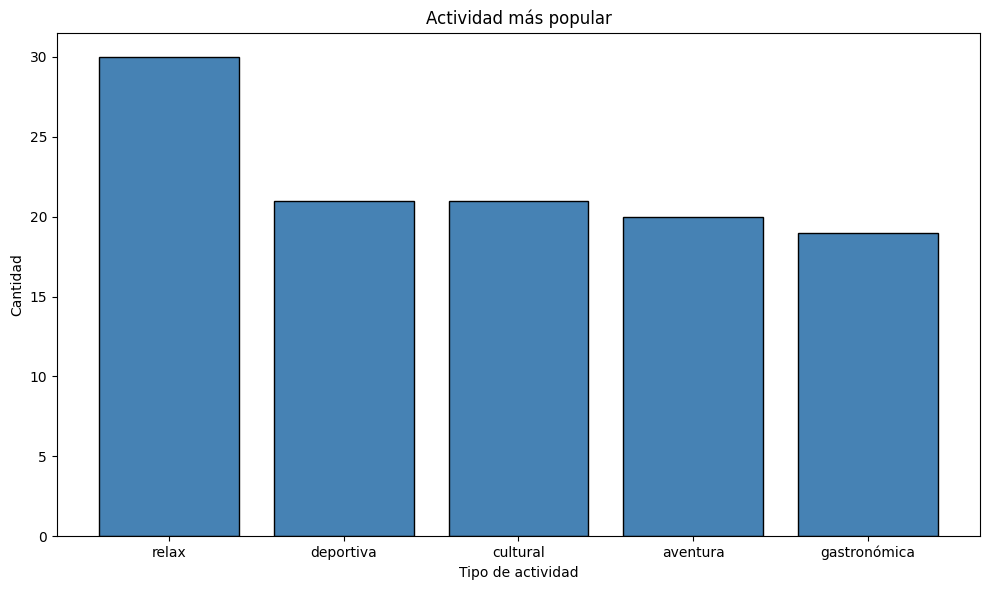

In [16]:
pipeline = [
    {"$group": {"_id":"$tipo", "cantidad": {"$sum":1}}},
    {"$project":{"_id":0,"tipo":"$_id", "cantidad": 1}},
    {"$sort": {"cantidad": -1}}
]

resultado = list(client[NOMBRE_BD_MONGO]["actividades"].aggregate(pipeline))

df = pd.DataFrame(resultado)
df = df[["tipo", "cantidad"]]
display(df.style.hide(axis="index"))

tipos=df["tipo"]
cantidades= df["cantidad"]

plt.figure(figsize=(10, 6))
plt.bar(tipos, cantidades, color="steelblue", edgecolor="black")

# Etiquetas y título
plt.xlabel("Tipo de actividad")
plt.ylabel("Cantidad")
plt.title("Actividad más popular")
plt.tight_layout()

plt.show()

#### Modificaciones

###### a.Incrementar el precio de las actividades de Tucuman en 5% 

###### b. Agregar al hotel id=1 el servicio de SPA 

In [ ]:
# Aca usamos la funcion update_one naque hotel

resultado = client[NOMBRE_BD_MONGO].hoteles.update_one(
    {"hotel_id": 1},
    {"$addToSet": {"servicios": "wifi"}}
)

if resultado.modified_count == 0:
    print("El servicio ya existe")
else:
    print(f"Modificados: {resultado.modified_count}")

In [ ]:
#Consulta para verificar que se agrego el servicio
cursor = mongo.obtener_cursor(NOMBRE_BD_MONGO,"hoteles",filtro={"hotel_id":1},proyeccion={"_id":0})
resultado = list(cursor)
resultado

###### c. Eliminar el destino que desee

###### d. Eliminar un usuario que desee 

###### e. Eliminar las relaciones AMIGO_DE para un usuario que quiera. 

In [ ]:
usuario_id = int(input("Ingrese el Usuario ID para borrar las relaciones AMIGO_DE: "))
eliminadas = neo4j.eliminar_amigos(usuario_id)
print(f"Se eliminaron {eliminadas} relaciones AMIGO_DE para el usuario_id: {usuario_id}")

In [ ]:
#Consulta para verificar la eliminación

query = """
MATCH (u:Usuario {usuario_id: $id})-[r:AMIGO_DE]-(amigo:Usuario)
RETURN u.usuario_id,type(r) as relacion,amigo.usuario_id
"""

resultado = neo4j.consulta(db_neo4j, query, parametros={"id": 15})
resultado